E-Commerce User Behavior Analysis (Cart Abandonment & Funnel Optimization)

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd

# Define file path
file_path = '/content/drive/My Drive/2019-Oct.csv'

In [5]:
# Read and process the file in chunks
chunk_size = 100_000  # Adjust based on your RAM and needs
chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # Example: Filter sessions with checkout events
    filtered = chunk[chunk['event_type'] == 'checkout']
    chunks.append(filtered)

# Combine all filtered chunks into a DataFrame
filtered_df = pd.concat(chunks, ignore_index=True)

# Check the resulting DataFrame
print(filtered_df.head())

Empty DataFrame
Columns: [event_time, event_type, product_id, category_id, category_code, brand, price, user_id, user_session]
Index: []


In [6]:
sample_df = pd.read_csv(file_path, nrows=100_000)
sample_df.head()


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [7]:
print(sample_df['event_type'].value_counts())


event_type
view        97130
purchase     1655
cart         1215
Name: count, dtype: int64


In [8]:
# How many unique users per event type?
views = sample_df[sample_df['event_type'] == 'view']['user_id'].nunique()
cart = sample_df[sample_df['event_type'] == 'cart']['user_id'].nunique()
purchase = sample_df[sample_df['event_type'] == 'purchase']['user_id'].nunique()

print(f"Views: {views}, Cart Adds: {cart}, Purchases: {purchase}")

# Conversion rates
cart_rate = cart / views * 100
purchase_rate = purchase / cart * 100
overall_purchase_rate = purchase / views * 100

print(f"View to Cart Conversion Rate: {cart_rate:.2f}%")
print(f"Cart to Purchase Conversion Rate: {purchase_rate:.2f}%")
print(f"View to Purchase Conversion Rate: {overall_purchase_rate:.2f}%")


Views: 20383, Cart Adds: 743, Purchases: 1336
View to Cart Conversion Rate: 3.65%
Cart to Purchase Conversion Rate: 179.81%
View to Purchase Conversion Rate: 6.55%


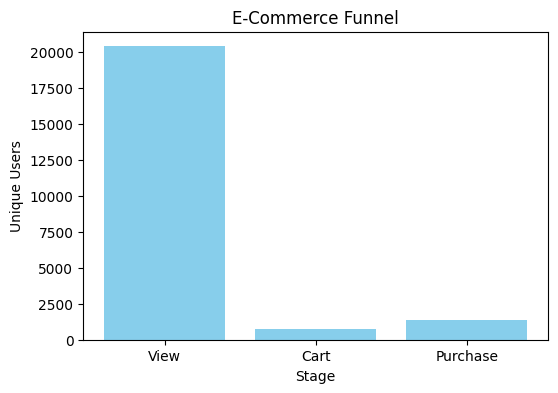

In [9]:
import matplotlib.pyplot as plt

stages = ['View', 'Cart', 'Purchase']
counts = [views, cart, purchase]

plt.figure(figsize=(6,4))
plt.bar(stages, counts, color='skyblue')
plt.title('E-Commerce Funnel')
plt.xlabel('Stage')
plt.ylabel('Unique Users')
plt.show()


In [10]:
# Find users who purchased but never added to cart
cart_users = set(sample_df[sample_df['event_type'] == 'cart']['user_id'])
purchase_users = set(sample_df[sample_df['event_type'] == 'purchase']['user_id'])
no_cart_before_purchase = purchase_users - cart_users
print(f"Users who purchased without ever adding to cart: {len(no_cart_before_purchase)}")


Users who purchased without ever adding to cart: 905


 **Session-based funnel and exploring deeper user behavior.**

Prepare the Data

In [11]:
sample_df = sample_df.sort_values(['user_id', 'user_session', 'event_time'])


Map Funnel Steps by Session
Let’s flag which sessions included a view, cart, or purchase:



In [12]:
# For each session, check if it contains a 'view', 'cart', or 'purchase'
funnel_by_session = (
    sample_df.groupby(['user_id', 'user_session'])['event_type']
    .agg(list)
    .reset_index()
)

def funnel_steps(events):
    return {
        'view': 'view' in events,
        'cart': 'cart' in events,
        'purchase': 'purchase' in events
    }

# Apply function to get funnel steps
funnel_flags = funnel_by_session['event_type'].apply(funnel_steps)
funnel_steps_df = pd.DataFrame(list(funnel_flags))
session_funnel = pd.concat([funnel_by_session[['user_id', 'user_session']], funnel_steps_df], axis=1)

print(session_funnel.head())


     user_id                          user_session  view   cart  purchase
0  306441847  47641f8a-3aba-471a-8d07-014deccec567  True  False     False
1  362699320  6c48ec39-b4be-4e62-a646-6c5d92de098c  True  False     False
2  370076704  8664f1b9-1405-4d14-a2a8-c15f299cf7e4  True  False     False
3  372804920  c7ca225b-fc10-4134-a5eb-1333cd6a87ea  True  False     False
4  372944259  1c817fed-1de0-4a5c-a80d-479f023a5ece  True  False     False


Calculate Session-Based Conversion Rates

In [13]:
sessions_with_view = session_funnel['view'].sum()
sessions_with_cart = session_funnel['cart'].sum()
sessions_with_purchase = session_funnel['purchase'].sum()

view_to_cart = session_funnel[(session_funnel['view']) & (session_funnel['cart'])].shape[0]
cart_to_purchase = session_funnel[(session_funnel['cart']) & (session_funnel['purchase'])].shape[0]
view_to_purchase = session_funnel[(session_funnel['view']) & (session_funnel['purchase'])].shape[0]

print(f"Sessions with view: {sessions_with_view}")
print(f"Sessions with cart: {sessions_with_cart}")
print(f"Sessions with purchase: {sessions_with_purchase}")
print(f"Sessions with both view and cart: {view_to_cart}")
print(f"Sessions with both cart and purchase: {cart_to_purchase}")
print(f"Sessions with both view and purchase: {view_to_purchase}")

# Conversion rates
print(f"View to Cart (per session): {view_to_cart / sessions_with_view * 100:.2f}%")
print(f"Cart to Purchase (per session): {cart_to_purchase / sessions_with_cart * 100:.2f}%")
print(f"View to Purchase (per session): {view_to_purchase / sessions_with_view * 100:.2f}%")


Sessions with view: 24377
Sessions with cart: 798
Sessions with purchase: 1431
Sessions with both view and cart: 798
Sessions with both cart and purchase: 441
Sessions with both view and purchase: 1425
View to Cart (per session): 3.27%
Cart to Purchase (per session): 55.26%
View to Purchase (per session): 5.85%


 Deep Dive - Analyze Time Between Events
 Calculate how long it takes for a user to move from view to cart and from cart to purchase within a session:

In [19]:
print(sample_df.columns.tolist())


['event_time', 'event_type', 'product_id', 'category_id', 'category_code', 'brand', 'price', 'user_id', 'user_session']


In [20]:
print(sample_df.head())


                     event_time event_type  product_id          category_id  \
1150  2019-10-01 01:32:09+00:00       view     2501614  2053013564003713919   
21849 2019-10-01 02:56:47+00:00       view     2501614  2053013564003713919   
28433 2019-10-01 03:05:49+00:00       view    26500447  2053013563550729061   
38470 2019-10-01 03:18:39+00:00       view    26203366  2053013563693335403   
40352 2019-10-01 03:20:58+00:00       view    26500136  2053013563550729061   

                 category_code    brand   price    user_id  \
1150   appliances.kitchen.oven  redmond  164.71  306441847   
21849  appliances.kitchen.oven  redmond  164.71  306441847   
28433                      NaN      NaN   26.77  362699320   
38470                      NaN      NaN  310.69  362699320   
40352                      NaN  lucente   91.38  362699320   

                               user_session  
1150   47641f8a-3aba-471a-8d07-014deccec567  
21849  47641f8a-3aba-471a-8d07-014deccec567  
28433  6c48ec3

Funnel by Brand

In [21]:
brand_results = []

for brand in sample_df['brand'].dropna().unique():
    temp = sample_df[sample_df['brand'] == brand]
    funnel = temp.groupby(['user_id', 'user_session'])['event_type'].agg(list).reset_index()
    steps = funnel['event_type'].apply(lambda x: {
        'view': 'view' in x,
        'cart': 'cart' in x,
        'purchase': 'purchase' in x
    })
    step_df = pd.DataFrame(list(steps))
    merged = pd.concat([funnel, step_df], axis=1)
    view = merged['view'].sum()
    cart = merged['cart'].sum()
    purchase = merged['purchase'].sum()
    view_cart = merged[(merged['view']) & (merged['cart'])].shape[0]
    cart_purchase = merged[(merged['cart']) & (merged['purchase'])].shape[0]
    view_purchase = merged[(merged['view']) & (merged['purchase'])].shape[0]
    brand_results.append({
        'brand': brand,
        'views': view,
        'carts': cart,
        'purchases': purchase,
        'view_to_cart(%)': view_cart / view * 100 if view else 0,
        'cart_to_purchase(%)': cart_purchase / cart * 100 if cart else 0,
        'view_to_purchase(%)': view_purchase / view * 100 if view else 0
    })

brand_funnel_df = pd.DataFrame(brand_results)
print(brand_funnel_df.sort_values('views', ascending=False).head(10))  # Top 10 brands by views


       brand  views  carts  purchases  view_to_cart(%)  cart_to_purchase(%)  \
7    samsung   4199    312        342         7.430341            61.858974   
23     apple   3773    208        248         5.512854            56.730769   
33    xiaomi   2385    106        118         4.444444            43.396226   
6     huawei   1036     53         58         5.115830            56.603774   
1    lucente    642      0         25         0.000000             0.000000   
42     bosch    572      4         12         0.699301            25.000000   
77        lg    424      6         17         1.415094            50.000000   
81  cordiant    386      9         13         2.331606            22.222222   
26  elenberg    382      0         12         0.000000             0.000000   
65  dauscher    378      0          7         0.000000             0.000000   

    view_to_purchase(%)  
7              8.144796  
23             6.493506  
33             4.947589  
6              5.598456  


Funnel by Category

In [22]:
cat_results = []

for cat in sample_df['category_code'].dropna().unique():
    temp = sample_df[sample_df['category_code'] == cat]
    funnel = temp.groupby(['user_id', 'user_session'])['event_type'].agg(list).reset_index()
    steps = funnel['event_type'].apply(lambda x: {
        'view': 'view' in x,
        'cart': 'cart' in x,
        'purchase': 'purchase' in x
    })
    step_df = pd.DataFrame(list(steps))
    merged = pd.concat([funnel, step_df], axis=1)
    view = merged['view'].sum()
    cart = merged['cart'].sum()
    purchase = merged['purchase'].sum()
    view_cart = merged[(merged['view']) & (merged['cart'])].shape[0]
    cart_purchase = merged[(merged['cart']) & (merged['purchase'])].shape[0]
    view_purchase = merged[(merged['view']) & (merged['purchase'])].shape[0]
    cat_results.append({
        'category': cat,
        'views': view,
        'carts': cart,
        'purchases': purchase,
        'view_to_cart(%)': view_cart / view * 100 if view else 0,
        'cart_to_purchase(%)': cart_purchase / cart * 100 if cart else 0,
        'view_to_purchase(%)': view_purchase / view * 100 if view else 0
    })

cat_funnel_df = pd.DataFrame(cat_results)
print(cat_funnel_df.sort_values('views', ascending=False).head(10))  # Top 10 categories by views


                            category  views  carts  purchases  \
3             electronics.smartphone   7853    563        646   
8                 electronics.clocks    997     21         33   
2        electronics.audio.headphone    921     54         64   
5                 computers.notebook    601      2         32   
27              electronics.video.tv    557     24         37   
10  appliances.kitchen.refrigerators    523      0         25   
49     appliances.environment.vacuum    429     16         33   
37                     apparel.shoes    419      0          8   
25         appliances.kitchen.washer    401      4         34   
36           auto.accessories.player    322      0          6   

    view_to_cart(%)  cart_to_purchase(%)  view_to_purchase(%)  
3          7.169235            60.568384             8.213422  
8          2.106319            61.904762             3.309930  
2          5.863192            42.592593             6.731813  
5          0.332779         

Funnel by Price Range
First, create a price bucket:

In [23]:
import numpy as np

# Define price bins (edit as appropriate for your data's price scale)
bins = [0, 50, 150, 500, 2000, np.inf]
labels = ['Low', 'Medium', 'High', 'Premium', 'Luxury']

sample_df['price_range'] = pd.cut(sample_df['price'], bins=bins, labels=labels)


In [24]:
price_results = []

for price_range in sample_df['price_range'].dropna().unique():
    temp = sample_df[sample_df['price_range'] == price_range]
    funnel = temp.groupby(['user_id', 'user_session'])['event_type'].agg(list).reset_index()
    steps = funnel['event_type'].apply(lambda x: {
        'view': 'view' in x,
        'cart': 'cart' in x,
        'purchase': 'purchase' in x
    })
    step_df = pd.DataFrame(list(steps))
    merged = pd.concat([funnel, step_df], axis=1)
    view = merged['view'].sum()
    cart = merged['cart'].sum()
    purchase = merged['purchase'].sum()
    view_cart = merged[(merged['view']) & (merged['cart'])].shape[0]
    cart_purchase = merged[(merged['cart']) & (merged['purchase'])].shape[0]
    view_purchase = merged[(merged['view']) & (merged['purchase'])].shape[0]
    price_results.append({
        'price_range': price_range,
        'views': view,
        'carts': cart,
        'purchases': purchase,
        'view_to_cart(%)': view_cart / view * 100 if view else 0,
        'cart_to_purchase(%)': cart_purchase / cart * 100 if cart else 0,
        'view_to_purchase(%)': view_purchase / view * 100 if view else 0
    })

price_funnel_df = pd.DataFrame(price_results)
print(price_funnel_df)


  price_range  views  carts  purchases  view_to_cart(%)  cart_to_purchase(%)  \
0        High  11212    386        600         3.442740            58.808290   
1         Low   6538     77        243         1.177730            36.363636   
2      Medium   9091    178        383         1.957980            54.494382   
3     Premium   6119    169        241         2.761889            55.621302   
4      Luxury    351      1          4         0.284900             0.000000   

   view_to_purchase(%)  
0             5.315733  
1             3.686143  
2             4.201958  
3             3.938552  
4             1.139601  


Plot: View-to-Purchase Conversion by Brand


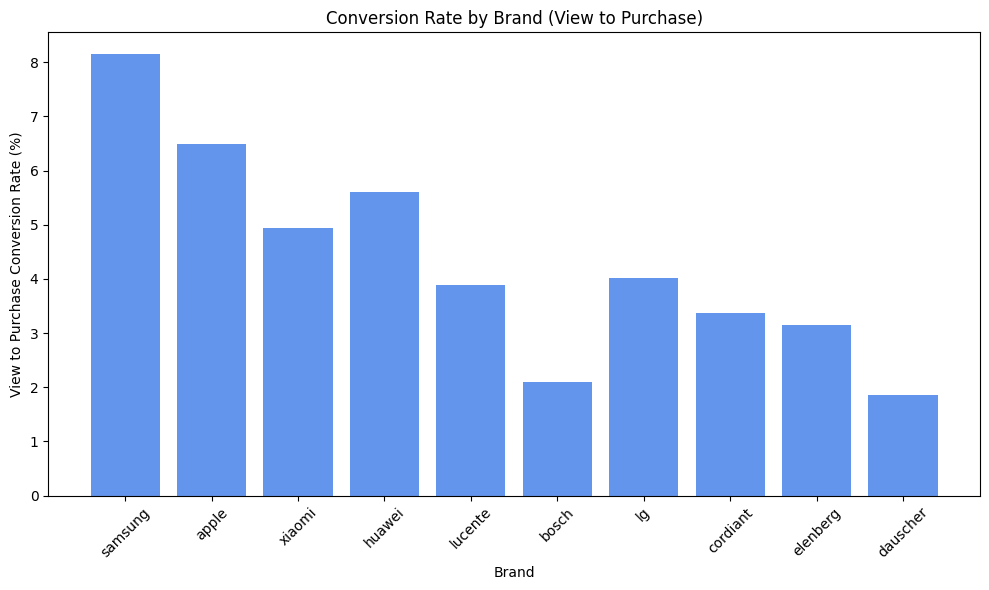

In [25]:
import matplotlib.pyplot as plt

# Select top 10 brands by views
top_brands = brand_funnel_df.sort_values('views', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_brands['brand'], top_brands['view_to_purchase(%)'], color='cornflowerblue')
plt.title('Conversion Rate by Brand (View to Purchase)')
plt.xlabel('Brand')
plt.ylabel('View to Purchase Conversion Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Plot: View-to-Purchase Conversion by Category

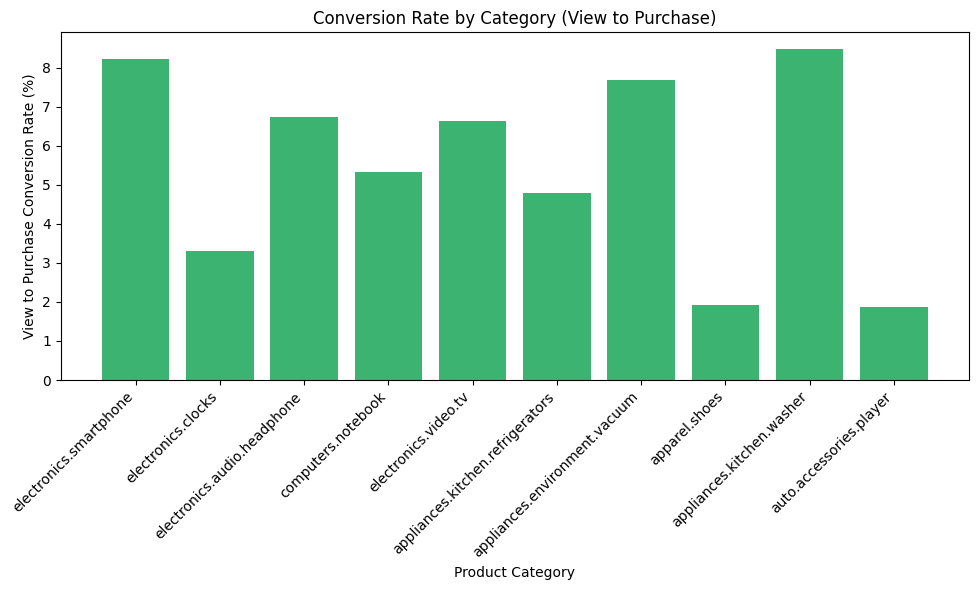

In [26]:
# Select top 10 categories by views
top_cats = cat_funnel_df.sort_values('views', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_cats['category'], top_cats['view_to_purchase(%)'], color='mediumseagreen')
plt.title('Conversion Rate by Category (View to Purchase)')
plt.xlabel('Product Category')
plt.ylabel('View to Purchase Conversion Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Plot: View-to-Purchase Conversion by Price Range

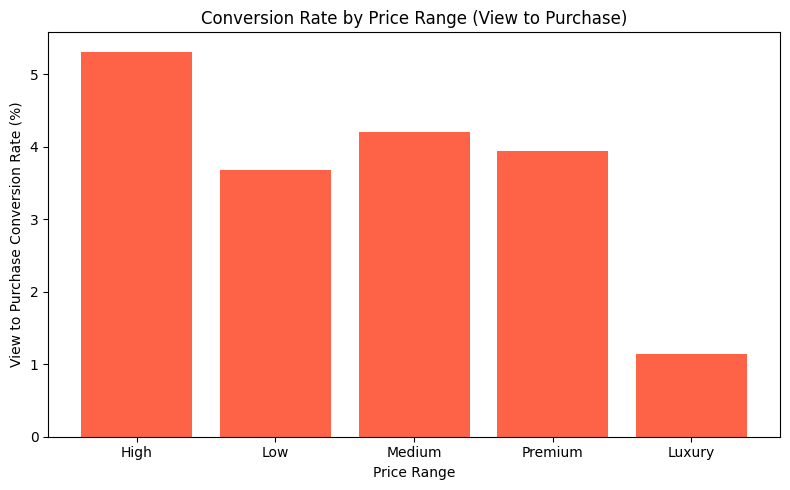

In [27]:
plt.figure(figsize=(8, 5))
plt.bar(price_funnel_df['price_range'].astype(str), price_funnel_df['view_to_purchase(%)'], color='tomato')
plt.title('Conversion Rate by Price Range (View to Purchase)')
plt.xlabel('Price Range')
plt.ylabel('View to Purchase Conversion Rate (%)')
plt.tight_layout()
plt.show()


In [36]:
!git config --global user.email "achyuthkumar603@gmail.com"
!git config --global user.name "achyuth098"

In [37]:
!git clone https://github.com/achyuth098/ecommerce-funnel-analysis.git


fatal: destination path 'ecommerce-funnel-analysis' already exists and is not an empty directory.


In [ ]:
import shutil
shutil.copy('your_notebook.ipynb', 'YOUR-REPO-NAME/')
# Repeat for images/other files as needed
